In [39]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [40]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [41]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [42]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flu

In [43]:
data.isna().sum()

Source_Name              0
Total_flux               0
Peak_flux                0
S_Code                   0
EBV                      0
FUV_flux_corr            0
NUV_flux_corr            0
u_flux_corr              0
Bw_flux_corr             0
R_flux_corr              0
I_flux_corr              0
z_flux_corr              0
z_Subaru_flux_corr       0
y_flux_corr              0
J_flux_corr              0
H_flux_corr              0
K_flux_corr              0
Ks_flux_corr             0
ch1_flux_corr            0
ch2_flux_corr            0
ch3_flux_corr            0
ch4_flux_corr            0
F_MIPS_24                0
F_PACS_100               0
F_PACS_160               0
F_SPIRE_250              0
F_SPIRE_350              0
F_SPIRE_500              0
Z_BEST                   0
Mass_median              0
Mass_l68                 0
Mass_u68                 0
Source                   0
AGN_final                0
RadioAGN_final           0
Classification           0
Radio_excess            21
A

In [44]:
X = data[features_num]
y = data[y_column]

In [45]:
le = LabelEncoder()
labels = np.unique(y.astype(str))
y = le.fit_transform(y)

In [120]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [121]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [122]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [123]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Random forest

In [106]:
clf = RandomForestClassifier(n_estimators=500, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight="balanced", 
                             random_state=42)
clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [26]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=10000, 
                             class_weight="balanced",
                             max_depth=7, 
                             num_leaves=32, 
                             min_child_samples=5,
                             reg_alpha=1,
                             reg_lambda=2,
                            early_stopping_round=50)

In [27]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True, 
                sample_weight=classes_weights)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 2.66374
[2]	valid_0's multi_logloss: 2.39159
[3]	valid_0's multi_logloss: 2.20562
[4]	valid_0's multi_logloss: 2.05872
[5]	valid_0's multi_logloss: 1.95076
[6]	valid_0's multi_logloss: 1.86032
[7]	valid_0's multi_logloss: 1.77873
[8]	valid_0's multi_logloss: 1.71628
[9]	valid_0's multi_logloss: 1.66043
[10]	valid_0's multi_logloss: 1.61466
[11]	valid_0's multi_logloss: 1.56933
[12]	valid_0's multi_logloss: 1.52984
[13]	valid_0's multi_logloss: 1.4962
[14]	valid_0's multi_logloss: 1.46544
[15]	valid_0's multi_logloss: 1.43379
[16]	valid_0's multi_logloss: 1.40705
[17]	valid_0's multi_logloss: 1.38137
[18]	valid_0's multi_logloss: 1.36081
[19]	valid_0's multi_logloss: 1.33556
[20]	valid_0's multi_logloss: 1.31694
[21]	valid_0's multi_logloss: 1.29676
[22]	valid_0's multi_logloss: 1.27397
[23]	valid_0's multi_logloss: 1.25549
[24]	valid_0's multi_logloss: 1.23746
[25]	valid_0's multi_logloss: 1.22275
[26]	valid_0's multi_logloss: 1.20575
[27]	valid_0's multi_l

[213]	valid_0's multi_logloss: 0.534897
[214]	valid_0's multi_logloss: 0.533972
[215]	valid_0's multi_logloss: 0.532932
[216]	valid_0's multi_logloss: 0.531772
[217]	valid_0's multi_logloss: 0.530634
[218]	valid_0's multi_logloss: 0.529491
[219]	valid_0's multi_logloss: 0.528419
[220]	valid_0's multi_logloss: 0.527022
[221]	valid_0's multi_logloss: 0.525902
[222]	valid_0's multi_logloss: 0.524493
[223]	valid_0's multi_logloss: 0.523247
[224]	valid_0's multi_logloss: 0.522272
[225]	valid_0's multi_logloss: 0.5212
[226]	valid_0's multi_logloss: 0.520162
[227]	valid_0's multi_logloss: 0.519357
[228]	valid_0's multi_logloss: 0.518119
[229]	valid_0's multi_logloss: 0.517128
[230]	valid_0's multi_logloss: 0.516076
[231]	valid_0's multi_logloss: 0.515086
[232]	valid_0's multi_logloss: 0.513447
[233]	valid_0's multi_logloss: 0.512588
[234]	valid_0's multi_logloss: 0.511163
[235]	valid_0's multi_logloss: 0.509786
[236]	valid_0's multi_logloss: 0.508958
[237]	valid_0's multi_logloss: 0.507599
[2

[422]	valid_0's multi_logloss: 0.397707
[423]	valid_0's multi_logloss: 0.397363
[424]	valid_0's multi_logloss: 0.397059
[425]	valid_0's multi_logloss: 0.396725
[426]	valid_0's multi_logloss: 0.396388
[427]	valid_0's multi_logloss: 0.396189
[428]	valid_0's multi_logloss: 0.395938
[429]	valid_0's multi_logloss: 0.395644
[430]	valid_0's multi_logloss: 0.395262
[431]	valid_0's multi_logloss: 0.394987
[432]	valid_0's multi_logloss: 0.394742
[433]	valid_0's multi_logloss: 0.394532
[434]	valid_0's multi_logloss: 0.39426
[435]	valid_0's multi_logloss: 0.394012
[436]	valid_0's multi_logloss: 0.393717
[437]	valid_0's multi_logloss: 0.393459
[438]	valid_0's multi_logloss: 0.393292
[439]	valid_0's multi_logloss: 0.393091
[440]	valid_0's multi_logloss: 0.392689
[441]	valid_0's multi_logloss: 0.392494
[442]	valid_0's multi_logloss: 0.392301
[443]	valid_0's multi_logloss: 0.392152
[444]	valid_0's multi_logloss: 0.391906
[445]	valid_0's multi_logloss: 0.39171
[446]	valid_0's multi_logloss: 0.391422
[4

[628]	valid_0's multi_logloss: 0.362321
[629]	valid_0's multi_logloss: 0.362248
[630]	valid_0's multi_logloss: 0.36209
[631]	valid_0's multi_logloss: 0.362014
[632]	valid_0's multi_logloss: 0.361962
[633]	valid_0's multi_logloss: 0.361848
[634]	valid_0's multi_logloss: 0.361698
[635]	valid_0's multi_logloss: 0.361614
[636]	valid_0's multi_logloss: 0.361496
[637]	valid_0's multi_logloss: 0.361401
[638]	valid_0's multi_logloss: 0.361361
[639]	valid_0's multi_logloss: 0.361364
[640]	valid_0's multi_logloss: 0.361317
[641]	valid_0's multi_logloss: 0.361184
[642]	valid_0's multi_logloss: 0.361143
[643]	valid_0's multi_logloss: 0.361038
[644]	valid_0's multi_logloss: 0.360959
[645]	valid_0's multi_logloss: 0.360936
[646]	valid_0's multi_logloss: 0.360799
[647]	valid_0's multi_logloss: 0.360669
[648]	valid_0's multi_logloss: 0.360535
[649]	valid_0's multi_logloss: 0.360432
[650]	valid_0's multi_logloss: 0.360333
[651]	valid_0's multi_logloss: 0.36021
[652]	valid_0's multi_logloss: 0.360158
[6

[834]	valid_0's multi_logloss: 0.351869
[835]	valid_0's multi_logloss: 0.351871
[836]	valid_0's multi_logloss: 0.351837
[837]	valid_0's multi_logloss: 0.351822
[838]	valid_0's multi_logloss: 0.351799
[839]	valid_0's multi_logloss: 0.351764
[840]	valid_0's multi_logloss: 0.35178
[841]	valid_0's multi_logloss: 0.351763
[842]	valid_0's multi_logloss: 0.351739
[843]	valid_0's multi_logloss: 0.351685
[844]	valid_0's multi_logloss: 0.35164
[845]	valid_0's multi_logloss: 0.351596
[846]	valid_0's multi_logloss: 0.351617
[847]	valid_0's multi_logloss: 0.351612
[848]	valid_0's multi_logloss: 0.351594
[849]	valid_0's multi_logloss: 0.351578
[850]	valid_0's multi_logloss: 0.351605
[851]	valid_0's multi_logloss: 0.35165
[852]	valid_0's multi_logloss: 0.351666
[853]	valid_0's multi_logloss: 0.351642
[854]	valid_0's multi_logloss: 0.351633
[855]	valid_0's multi_logloss: 0.351672
[856]	valid_0's multi_logloss: 0.351671
[857]	valid_0's multi_logloss: 0.351665
[858]	valid_0's multi_logloss: 0.351634
[85

LGBMClassifier(class_weight='balanced', early_stopping_round=50, max_depth=7,
               min_child_samples=5, n_estimators=10000, num_class=4,
               num_leaves=64, objective='multiclass', reg_alpha=1,
               reg_lambda=2)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [28]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7716    0.8652    0.8157      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5000    0.5000    0.5000       270
                                     radio-quiet AGN     0.6695    0.8201    0.7372      1356
                                 star-forming galaxy     0.9551    0.9030    0.9283     11315

                                            accuracy                         0.8824     15522
                                           macro avg     0.7241    0.7720    0.7453     15522
                                        weighted avg     0.8917    0.8824    0.8854     15522



[]

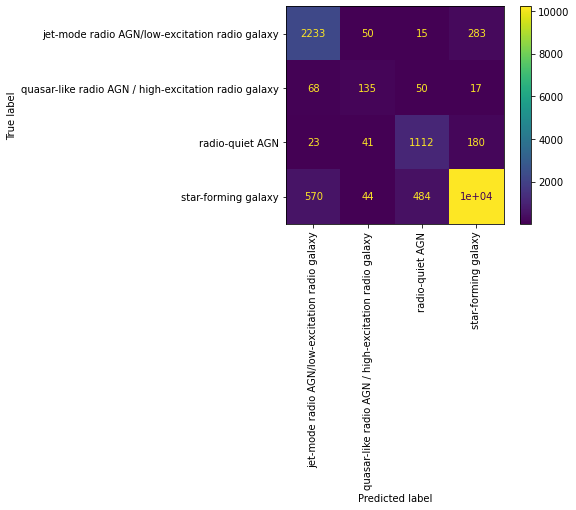

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [111]:
classes_weights2 = classes_weights.copy()
classes_weights2[classes_weights2>10] = classes_weights2[classes_weights2>10] = 100

In [129]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=0, 
                      min_child_weight=0.5, 
                      reg_lambda=1,
                      eta=0.3,
                      tree_method='exact',
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=10000, 
                      early_stopping_rounds=20,
                      subsample=0.5,)

In [130]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_test, y_test)], verbose=True, 
                sample_weight=classes_weights) # Maybe remove weight

[0]	validation_0-merror:0.21144	validation_0-auc:0.89840
[1]	validation_0-merror:0.19495	validation_0-auc:0.91692
[2]	validation_0-merror:0.18889	validation_0-auc:0.92298
[3]	validation_0-merror:0.18271	validation_0-auc:0.92898
[4]	validation_0-merror:0.18090	validation_0-auc:0.93148
[5]	validation_0-merror:0.17594	validation_0-auc:0.93435
[6]	validation_0-merror:0.17395	validation_0-auc:0.93635
[7]	validation_0-merror:0.17169	validation_0-auc:0.93904
[8]	validation_0-merror:0.16879	validation_0-auc:0.94095
[9]	validation_0-merror:0.16783	validation_0-auc:0.94259
[10]	validation_0-merror:0.16589	validation_0-auc:0.94457
[11]	validation_0-merror:0.16306	validation_0-auc:0.94615
[12]	validation_0-merror:0.16100	validation_0-auc:0.94672
[13]	validation_0-merror:0.15784	validation_0-auc:0.94780
[14]	validation_0-merror:0.15597	validation_0-auc:0.94888
[15]	validation_0-merror:0.15559	validation_0-auc:0.94988
[16]	validation_0-merror:0.15327	validation_0-auc:0.95083
[17]	validation_0-merror

[141]	validation_0-merror:0.10707	validation_0-auc:0.96417
[142]	validation_0-merror:0.10772	validation_0-auc:0.96425
[143]	validation_0-merror:0.10727	validation_0-auc:0.96429
[144]	validation_0-merror:0.10765	validation_0-auc:0.96432
[145]	validation_0-merror:0.10772	validation_0-auc:0.96437
[146]	validation_0-merror:0.10810	validation_0-auc:0.96440
[147]	validation_0-merror:0.10817	validation_0-auc:0.96440
[148]	validation_0-merror:0.10752	validation_0-auc:0.96437
[149]	validation_0-merror:0.10740	validation_0-auc:0.96441
[150]	validation_0-merror:0.10740	validation_0-auc:0.96440
[151]	validation_0-merror:0.10694	validation_0-auc:0.96448
[152]	validation_0-merror:0.10669	validation_0-auc:0.96449
[153]	validation_0-merror:0.10694	validation_0-auc:0.96452
[154]	validation_0-merror:0.10637	validation_0-auc:0.96447
[155]	validation_0-merror:0.10611	validation_0-auc:0.96459
[156]	validation_0-merror:0.10585	validation_0-auc:0.96453
[157]	validation_0-merror:0.10585	validation_0-auc:0.964

[280]	validation_0-merror:0.10186	validation_0-auc:0.96639
[281]	validation_0-merror:0.10179	validation_0-auc:0.96637
[282]	validation_0-merror:0.10205	validation_0-auc:0.96636
[283]	validation_0-merror:0.10211	validation_0-auc:0.96639
[284]	validation_0-merror:0.10256	validation_0-auc:0.96641
[285]	validation_0-merror:0.10198	validation_0-auc:0.96642
[286]	validation_0-merror:0.10186	validation_0-auc:0.96643
[287]	validation_0-merror:0.10205	validation_0-auc:0.96640
[288]	validation_0-merror:0.10198	validation_0-auc:0.96642
[289]	validation_0-merror:0.10186	validation_0-auc:0.96642
[290]	validation_0-merror:0.10224	validation_0-auc:0.96644
[291]	validation_0-merror:0.10237	validation_0-auc:0.96647
[292]	validation_0-merror:0.10244	validation_0-auc:0.96650
[293]	validation_0-merror:0.10244	validation_0-auc:0.96653
[294]	validation_0-merror:0.10256	validation_0-auc:0.96651
[295]	validation_0-merror:0.10308	validation_0-auc:0.96650
[296]	validation_0-merror:0.10282	validation_0-auc:0.966

In [91]:
dir(bst)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_early_stopping_attr',
 '_estimator_type',
 '_get_iteration_range',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 'apply',
 'base_score',
 'best_iteration',
 'best_ntree_limit',
 'best_score',
 'booster',
 'callbacks',
 'classes_',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'early_stopping_rounds',
 'en

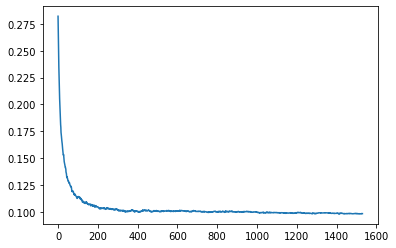

In [116]:
errors = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors)), errors)

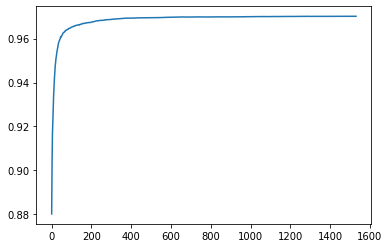

In [117]:
errors = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors)), errors)

In [225]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

In [123]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

NameError: name 'cv_score_xgb' is not defined

In [131]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8345    0.8202    0.8273      2581
quasar-like radio AGN / high-excitation radio galaxy     0.6085    0.4259    0.5011       270
                                     radio-quiet AGN     0.7405    0.7493    0.7449      1356
                                 star-forming galaxy     0.9346    0.9436    0.9391     11315

                                            accuracy                         0.8971     15522
                                           macro avg     0.7795    0.7348    0.7531     15522
                                        weighted avg     0.8953    0.8971    0.8959     15522



[]

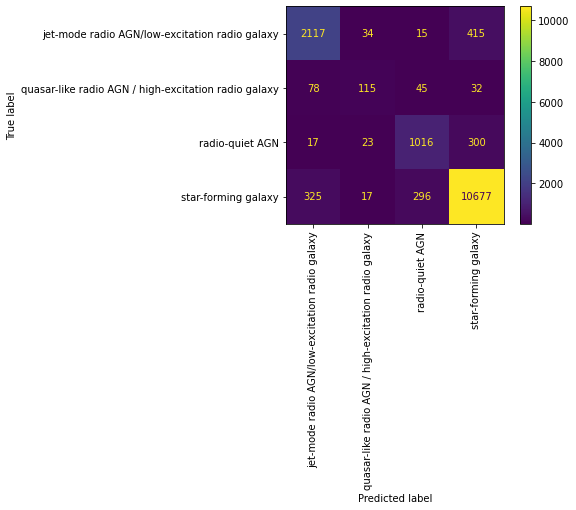

In [132]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

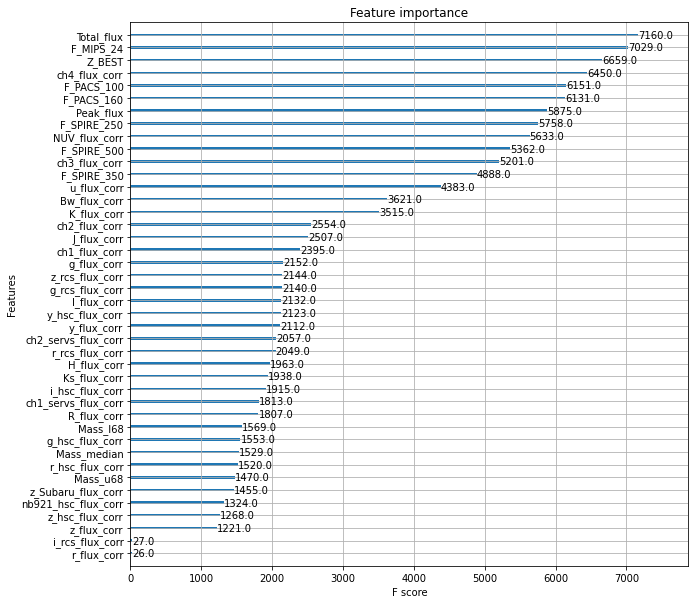

In [133]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

## Hyperparameter fitting

In [11]:
import multiprocessing

multiprocessing.cpu_count()

192

In [13]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [14]:
# Parameter space
parameters = { 
         "max_depth": [8,9,10,11],
         "reg_alpha": [0,1,3,5], 
        "reg_lambda": [0,1,3,5],
        "gamma": [0,0.5,3],
        "eta": [0.1, 0.3],
        "min_child_weight": [0, 0.2, 0.5, 1]}

In [15]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,)

In [16]:
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=128,
                  cv=2,
                  verbose=1)

grid = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits


/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
clf.best_params_, clf.best_score_

({'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841)

In [ ]:
bui{'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841

In [20]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=400, 
                     **clf.best_params_)

In [21]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=32,  n_jobs=32, scoring="accuracy")

In [22]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.89821 ± 0.00676


In [35]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,
                     **clf.best_params_)

In [36]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# DNN

In [77]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [83]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [84]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [85]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=1000,
    #callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dic,
)

Epoch 1/1000
971/971 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.1642 - val_loss: nan - val_accuracy: 0.1663
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.1641 - val_loss: nan - val_accuracy: 0.1663
Epoch 3/1000
675/971 [===================>..........] - ETA: 0s - loss: nan - accuracy: 0.1638

KeyboardInterrupt: 